In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!git clone https://github.com/dongbeank/CATS.git
%cd CATS

Cloning into 'CATS'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 74 (delta 5), reused 4 (delta 4), pack-reused 60 (from 1)
Receiving objects: 100% (74/74), 1005.08 KiB | 32.42 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/CATS


In [10]:
!pip install -r requirements.txt
!pip install pandas numpy torch matplotlib scikit-learn

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23

In [2]:
import pandas as pd

# Load your datasets (skip if already loaded)
customers = pd.read_csv('/content/Customer-Dataset.csv')
retail = pd.read_csv('/content/Retail-Dataset.csv')
logistics = pd.read_csv('/content/Logistic-Dataset.csv')

# Merge all on Customer_ID
merged_df = pd.merge(logistics, customers, on="Customer_ID", how="inner")
merged_df = pd.merge(merged_df, retail, on="Customer_ID", how="inner")

# Convert date column
merged_df['shipping_date'] = pd.to_datetime(merged_df['shipping_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['shipping_date'])

# Sort for time series modeling
merged_df = merged_df.sort_values(by='shipping_date')

# Select relevant features for modeling
features = ['sales_per_customer', 'profit_per_order']
target = 'label'

# Drop rows with NA in important fields
merged_df = merged_df.dropna(subset=features + [target])



<ipython-input-2-8adfd4227b65>:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  merged_df['shipping_date'] = pd.to_datetime(merged_df['shipping_date'], errors='coerce')


In [3]:
import numpy as np

def create_sliding_windows(df, feature_cols, label_col, window_size=10):
    data = []
    labels = []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size][feature_cols].values
        label = df.iloc[i+window_size][label_col]
        data.append(window)
        labels.append(label)
    return np.array(data), np.array(labels)

X, y = create_sliding_windows(merged_df, features, target)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_flat = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_flat).reshape(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to torch tensors
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Simple LSTM or attention model (replace with CATS if integrated)
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=X.shape[2], hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

model = SimpleLSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


Epoch 1 Loss: 0.7210
Epoch 2 Loss: 0.6393
Epoch 3 Loss: 0.5915
Epoch 4 Loss: 0.4056
Epoch 5 Loss: 0.5947
Epoch 6 Loss: 0.5505
Epoch 7 Loss: 0.3484
Epoch 8 Loss: 0.4194
Epoch 9 Loss: 0.5226
Epoch 10 Loss: 0.5933


In [6]:
model.eval()
with torch.no_grad():
    test_pred = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    test_loss = loss_fn(test_pred, torch.tensor(y_test, dtype=torch.float32))
    print(f"Test MSE: {test_loss.item():.4f}")


Test MSE: 1.0326


In [7]:
attention_outputs = model(torch.tensor(X_test, dtype=torch.float32))

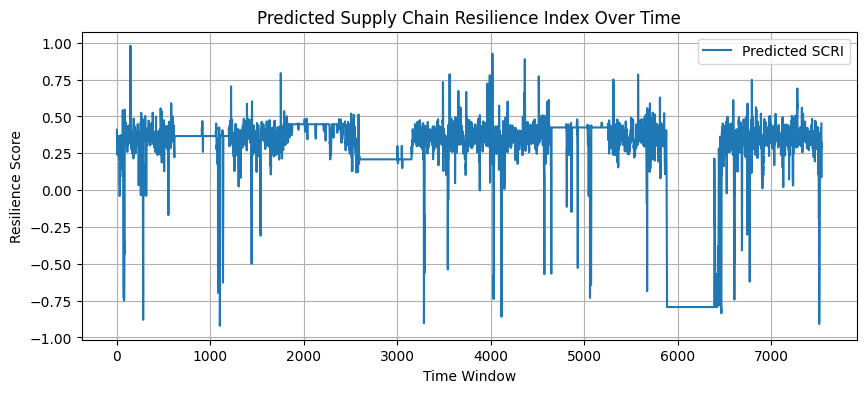

In [8]:
import matplotlib.pyplot as plt

predicted = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

# Plot predicted resilience scores
plt.figure(figsize=(10, 4))
plt.plot(predicted, label="Predicted SCRI")
plt.title("Predicted Supply Chain Resilience Index Over Time")
plt.xlabel("Time Window")
plt.ylabel("Resilience Score")
plt.legend()
plt.grid(True)
plt.show()
